# Agentic Policy Transaction Compliance Checker

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mongodb-developer/GenAI-Showcase/blob/main/notebooks/agents/agentic_policy_transaction_compliance_checker.ipynb)

## Description
This notebook builds an intelligent agentic system that automatically analyzes financial transactions against relevant regulatory policies to detect potential violations and compliance issues. The system leverages advanced NLP, vector search, and agent-based workflows to provide comprehensive transaction analysis with clear explanations and recommended actions.

## Use Case
Financial institutions face increasingly complex regulatory landscapes, with different countries imposing various reporting requirements and transaction restrictions. Compliance officers must:

1. Screen all transactions against multiple regulatory frameworks
2. Identify transactions that exceed reporting thresholds or require special attention
3. Generate documentation explaining policy violations and recommended actions
4. Maintain audit trails for regulatory inspections

This system automates these processes by:

- Embedding financial transactions and regulatory policies in a vector space
- Using semantic similarity to match transactions with relevant policies
- Applying a specialized LLM to determine if a transaction violates policies
- Generating detailed compliance reports with confidence scores
- Updating transaction records with compliance statuses and explanations

## Tools and Solutions Overview
**Data Storage and Retrieval**

- MongoDB Atlas: Serves as both operational and vector - database
- Vector Embeddings: Uses Voyage AI's embedding model for semantic search
- Vector Search: Efficiently retrieves relevant policies for transactions

**Machine Learning Models**

- Voyage AI: Generates embeddings for transactions and policies
- ShieldGemma: Specialized model for determining policy violations
- Claude: Powers the conversational agent interface

**Development Framework**

- LangChain: Provides tools, agents, and workflow components
- LangGraph: Orchestrates the multi-step compliance checking workflow
- Pydantic: Ensures data validation and schema enforcement

**Workflow Components**

- Transaction Processing Tools: Extract and analyze transaction details
- Policy Compliance Checkers: Compare transactions against policies
- Status Update Tools: Record compliance decisions and explanations
- Conversational Agent: Provides natural language interface for compliance officers


## Step 1: Install Libaries

In [ ]:
%pip install --quiet -U datasets pandas pymongo pydantic email-validator voyageai openai tqdm torch transformers memorizz

In [ ]:
%pip install --quiet -U langchain langchain_mongodb langgraph langgraph-checkpoint-mongodb langsmith motor langchain_anthropic torchvision accelerator

## Step 2: Add Environment Variables

In [ ]:
import os
import getpass

# Function to securely get and set environment variables
def set_env_securely(var_name, prompt):
  value = getpass.getpass(prompt)
  os.environ[var_name] = value

In [ ]:
# Non-sensitive environment variables
VOYAGE_AI_EMBEDDING_MODEL = "voyage-3-large"
VOYAGE_AI_EMBEDDING_MODEL_DIMENSION = 1024

# Uncomment below to utilize langSmith
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
# os.environ["LANGCHAIN_PROJECT"] = "factory_safety_assistant

In [ ]:
# Sensitive Environment Variables
set_env_securely("VOYAGE_API_KEY", "Enter your VOYAGE AI API key: ")
# Uncomment below to utilize langSmith
# set_env_securely("LANGCHAIN_API_KEY", "Enter your LangChain API key: ")

Enter your VOYAGE AI API key: ··········


In [ ]:
DB_NAME = "financial_transactions"

# Step 3: Data Loading and Preparation

In [ ]:
import pandas as pd
from datasets import load_dataset

# Make sure you have an Hugging Face token(HF_TOKEN) in your development environemnt before running the code below
# How to get a token: https://huggingface.co/docs/hub/en/security-tokens
# https://huggingface.co/datasets/MongoDB/fake_tech_companies_market_reports
policy_ds = load_dataset("MongoDB/finance_transactional_policies", split="train")

country_policies_df = pd.DataFrame(policy_ds)
country_policies_df.head()

country_policies.json:   0%|          | 0.00/121k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100 [00:00<?, ? examples/s]

,policy_id,country,policy_name,description,regulations,last_updated,enforcement_agency
0,c986fd06-9267-43ed-b695-bb9c1011f5c4,USA,USA Financial Regulation Act,Policy to regulate financial transactions and ...,"[{'action_required': 'report', 'currency': 'US...",2020-07-21,"{'contact': {'email': 'contact@fce.usa.gov', '..."
1,e95379ba-a9ec-4388-bbba-79e27eb45455,Australia,Australia Financial Regulation Act,Policy to regulate financial transactions and ...,"[{'action_required': 'report', 'currency': 'AU...",2023-07-08,{'contact': {'email': 'contact@fce.australia.g...
2,55222eb1-107c-4848-8814-11386ce9bfd1,India,India Financial Regulation Act,Policy to regulate financial transactions and ...,"[{'action_required': 'report', 'currency': 'AU...",2020-05-21,"{'contact': {'email': 'contact@fce.india.gov',..."
3,cb73a796-9bfa-4203-bc50-3d389ca5c05b,Germany,Germany Financial Regulation Act,Policy to regulate financial transactions and ...,"[{'action_required': 'report', 'currency': 'CA...",2023-09-07,{'contact': {'email': 'contact@fce.germany.gov...
4,45301718-3d83-408f-b1f5-85850a5978da,France,France Financial Regulation Act,Policy to regulate financial transactions and ...,"[{'action_required': 'report', 'currency': 'EU...",2022-06-21,{'contact': {'email': 'contact@fce.france.gov'...


In [ ]:
from pydantic import BaseModel, Field, EmailStr
from typing import List, Optional
from datetime import datetime
from bson.binary import Binary, BinaryVectorDtype


class Contact(BaseModel):
  phone: str
  email: EmailStr

class EnforcementAgency(BaseModel):
  name: str
  contact: Contact

class Regulation(BaseModel):
  regulation_id: str
  description: str
  threshold: Optional[int] = None
  currency: Optional[str] = None
  action_required: str

class Policy(BaseModel):
  policy_id: str
  country: str
  policy_name: str
  description: str
  regulations: List[Regulation]
  last_updated: datetime
  enforcement_agency: EnforcementAgency
  embedding: Optional[List[float]] = None


In [ ]:
from pydantic import ValidationError

def row_to_policy(row):
  try:
    # Convert the row to a dictionary
    policy_dict = row.to_dict()

    # Parse the date string to a date object
    policy_dict['last_updated'] = pd.to_datetime(policy_dict['last_updated']).date()

    # Create and return a Policy object
    return Policy(**policy_dict)
  except ValidationError as e:
    print(f"Validation error for policy {policy_dict.get('policy_id', 'Unknown')}: {e}")
    return None

In [ ]:
# Convert each row to a Policy object
policy_objects = country_policies_df.apply(row_to_policy, axis=1)

In [ ]:
policy_objects[0]

Policy(policy_id='c986fd06-9267-43ed-b695-bb9c1011f5c4', country='USA', policy_name='USA Financial Regulation Act', description='Policy to regulate financial transactions and prevent illicit activities in USA.', regulations=[Regulation(regulation_id='6d5c0ccd-35b0-469a-8813-d5b28b2238a6', description='All transactions exceeding $10,000 must be reported to the national financial authority.', threshold=10000, currency='USD', action_required='report'), Regulation(regulation_id='7c491ae1-6cd9-413d-84d5-807c4306d6f7', description='Financial institutions must verify the identity of all parties involved in transactions.', threshold=None, currency=None, action_required='identity_verification')], last_updated=datetime.datetime(2020, 7, 21, 0, 0), enforcement_agency=EnforcementAgency(name='USA Financial Crimes Enforcement Agency', contact=Contact(phone='718-324-0672x636', email='contact@fce.usa.gov')), embedding=None)

# Step 4: Setting up MongoDB as a Toolbox with MemoRizz
The `memorizz` library provides functionality to use MongoDB as a toolbox for storing and retrieving function definitions. Here's how to use this feature:

### Setup

To use MongoDB as a toolbox, you will need to complete the following steps:

1. Register for a MongoDB Account:
   - Go to the MongoDB website (https://www.mongodb.com/cloud/atlas/register).
   - Click on the "Try Free" or "Get Started Free" button.
   - Fill out the registration form with your details and create an account.

2. Create a [MongoDB Cluster](https://www.mongodb.com/docs/atlas/tutorial/deploy-free-tier-cluster/#procedure)

3. Set Up [Database Access](https://www.mongodb.com/docs/atlas/security-add-mongodb-users/#add-database-users):
   - In the left sidebar, click on "Database Access" under "Security".
   - Click "Add New Database User".
   - Create a username and a strong password. Save these credentials securely.
   - Set the appropriate permissions for the user (e.g., "Read and write to any database").

4. Configure Network Access:
   - In the left sidebar, click on "Network Access" under "Security".
   - Click "Add IP Address".
   - To allow access from anywhere (not recommended for production), enter 0.0.0.0/0.
   - For better security, whitelist only the specific IP addresses that need access.

5. Obtain the [MongoDB URI](https://www.mongodb.com/docs/manual/reference/connection-string/#find-your-mongodb-atlas-connection-string):

Now that you have your MongoDB URI, you can use it to connect to your cluster in the `memorizz` library.

In [ ]:
MONGO_URI = getpass.getpass("Enter MongoDB URI: ")
os.environ["MONGO_URI"] = MONGO_URI

Enter MongoDB URI: ··········


In [ ]:
from memorizz.database.mongodb import MongoDBToolsConfig, MongoDBTools

# Initialize the MongoDB configuration and create a MongoDB tools instance
config = MongoDBToolsConfig(
    mongo_uri=MONGO_URI,  # MongoDB connection string
    db_name=DB_NAME,  # Name of the database to use
    collection_name="tools",  # Name of the collection to store tools
    embedding_model=VOYAGE_AI_EMBEDDING_MODEL,  # OpenAI model for generating embeddings
    embeding_dimensions_size=VOYAGE_AI_EMBEDDING_MODEL_DIMENSION,  # Dimension size for the embedding vectors
    vector_search_candidates=150,  # Number of candidates to consider in vector search
    vector_index_name="vector_index"  # Name of the vector index in MongoDB
)

# Create an instance of MongoDBTools with the configured settings
mongodb_tools = MongoDBTools(config)

# Create a decorator function for registering tools
mongodb_toolbox = mongodb_tools.mongodb_toolbox

# Step 5: Embedding Generation

In [ ]:
from langchain.agents import tool
from typing import Optional
import voyageai

# Initialize the Voyage AI client.
client = voyageai.Client()

@tool
def get_embedding(text, task_prefix="document"):
  """
  Generate embeddings for a text string with a task-specific prefix using the voyage-3-large model.

  Parameters:
      text (str): The input text to be embedded.
      task_prefix (str): A prefix describing the task; this is prepended to the text.

  Returns:
      list: The embedding vector as a list of floats (or ints if another output_dtype is chosen).
  """
  if not text.strip():
      print("Attempted to get embedding for empty text.")
      return []

  # Call the Voyage API to generate the embedding.
  # Here, we wrap the text in a list since the API expects a list of texts.
  # Default output embedding: 1024
  result = client.embed([text], model=VOYAGE_AI_EMBEDDING_MODEL, input_type=task_prefix)

  # Return the first embedding from the result.
  return result.embeddings[0]

In [ ]:
def prepare_policy_text(policy: Policy) -> str:
  """Prepare relevant text from a policy for embedding."""
  regulations_text = " ".join([f"{reg.description} (Action: {reg.action_required})" for reg in policy.regulations])

  return f"""
  Country: {policy.country}
  Policy Name: {policy.policy_name}
  Description: {policy.description}
  Regulations: {regulations_text}
  """

In [ ]:
from bson.binary import Binary, BinaryVectorDtype

def generate_bson_vector(array, data_type):
    return Binary.from_vector(array, BinaryVectorDtype(data_type))

In [ ]:
def add_embedding_to_policy(policy: Policy) -> Policy:
    text = prepare_policy_text(policy)
    embedding = get_embedding(text)
    # Convert the embedding field in the datapoint to a list of BinData objects
    policy.embedding = generate_bson_vector(embedding, BinaryVectorDtype.FLOAT32)
    return policy

In [ ]:
from tqdm.auto import tqdm

def add_embeddings_with_progress(data, add_embedding_func):
    """
    Apply the embedding function to each item in the data,
    showing a progress bar.
    """
    total = len(data)
    return [add_embedding_func(item) for item in tqdm(data, total=total, desc="Generating embeddings")]

In [ ]:
# For policies
policies_with_embeddings = add_embeddings_with_progress(policy_objects, add_embedding_to_policy)

Generating embeddings:   0%|          | 0/100 [00:00<?, ?it/s]

# Step 6: MongoDB (Operational and Vector Database)

MongoDB acts as both an operational and a vector database for the RAG system.
MongoDB Atlas specifically provides a database solution that efficiently stores, queries and retrieves vector embeddings.

Creating a database and collection within MongoDB is made simple with MongoDB Atlas.

1. First, register for a [MongoDB Atlas account](https://www.mongodb.com/cloud/atlas/register). For existing users, sign into MongoDB Atlas.
2. [Follow the instructions](https://www.mongodb.com/docs/atlas/tutorial/deploy-free-tier-cluster/). Select Atlas UI as the procedure to deploy your first cluster.

Follow MongoDB’s [steps to get the connection](https://www.mongodb.com/docs/manual/reference/connection-string/) string from the Atlas UI. After setting up the database and obtaining the Atlas cluster connection URI, securely store the URI within your development environment.


In [ ]:
import pymongo

def get_mongo_client(mongo_uri):
  """Establish and validate connection to the MongoDB."""

  client = pymongo.MongoClient(mongo_uri, appname="devrel.showcase.rag.regulatory_compliance.python")

  # Validate the connection
  ping_result = client.admin.command('ping')
  if ping_result.get('ok') == 1.0:
    # Connection successful
    print("Connection to MongoDB successful")
    return client
  else:
    print("Connection to MongoDB failed")
  return None

if not MONGO_URI:
  print("MONGO_URI not set in environment variables")

In [ ]:
from pymongo.errors import CollectionInvalid

mongo_client = get_mongo_client(MONGO_URI)
db = mongo_client[DB_NAME]

# Define the collections we need to ensure exist
collections_to_create = ["transactions", "policies"]

# Cache existing collection names for faster lookups
existing_collections = set(db.list_collection_names())

# Loop over each collection name, creating it if it doesn't exist
for collection_name in collections_to_create:
  if collection_name not in existing_collections:
    try:
      db.create_collection(collection_name)
      print(f"Collection '{collection_name}' created successfully.")
    except CollectionInvalid as e:
      print(f"Error creating collection '{collection_name}': {e}")
  else:
      print(f"Collection '{collection_name}' already exists.")

# Retrieve the collections for further use
transactions_collection = db["transactions"]
policies_collection = db["policies"]


Connection to MongoDB successful
Collection 'transactions' already exists.
Collection 'policies' already exists.


In [ ]:
policies_collection.delete_many({})

DeleteResult({'n': 0, 'electionId': ObjectId('7fffffff000000000000003e'), 'opTime': {'ts': Timestamp(1741370756, 1), 't': 62}, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1741370756, 1), 'signature': {'hash': b'jwr\x16r\xa7I\x90n\xf3\xe6\x04\xcb*#\xefW\xe5\x19\x03', 'keyId': 7421923411288391683}}, 'operationTime': Timestamp(1741370756, 1)}, acknowledged=True)

# Step 7: Data Ingestion

In [ ]:
policies_dicts = [p.model_dump() for p in tqdm(policies_with_embeddings, desc="Preparing policies")]

Preparing policies:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
policies_collection.insert_many(policies_dicts, ordered=False)

InsertManyResult([ObjectId('67cb36e05e1ca2af02b2b266'), ObjectId('67cb36e05e1ca2af02b2b267'), ObjectId('67cb36e05e1ca2af02b2b268'), ObjectId('67cb36e05e1ca2af02b2b269'), ObjectId('67cb36e05e1ca2af02b2b26a'), ObjectId('67cb36e05e1ca2af02b2b26b'), ObjectId('67cb36e05e1ca2af02b2b26c'), ObjectId('67cb36e05e1ca2af02b2b26d'), ObjectId('67cb36e05e1ca2af02b2b26e'), ObjectId('67cb36e05e1ca2af02b2b26f'), ObjectId('67cb36e05e1ca2af02b2b270'), ObjectId('67cb36e05e1ca2af02b2b271'), ObjectId('67cb36e05e1ca2af02b2b272'), ObjectId('67cb36e05e1ca2af02b2b273'), ObjectId('67cb36e05e1ca2af02b2b274'), ObjectId('67cb36e05e1ca2af02b2b275'), ObjectId('67cb36e05e1ca2af02b2b276'), ObjectId('67cb36e05e1ca2af02b2b277'), ObjectId('67cb36e05e1ca2af02b2b278'), ObjectId('67cb36e05e1ca2af02b2b279'), ObjectId('67cb36e05e1ca2af02b2b27a'), ObjectId('67cb36e05e1ca2af02b2b27b'), ObjectId('67cb36e05e1ca2af02b2b27c'), ObjectId('67cb36e05e1ca2af02b2b27d'), ObjectId('67cb36e05e1ca2af02b2b27e'), ObjectId('67cb36e05e1ca2af02b2b2

# Step 8: Vector Index Creation

In [ ]:
# Programmatically create vector search index for both colelctions
import time
from pymongo.operations import SearchIndexModel

def setup_vector_search_index_with_filter(collection, index_definition, index_name="vector_index_with_filter"):
  """
  Setup a vector search index for a MongoDB collection.

  Args:
  collection: MongoDB collection object
  index_definition: Dictionary containing the index definition
  index_name: Name of the index (default: "vector_index_with_filter")
  """
  new_vector_search_index_model = SearchIndexModel(
      definition=index_definition,
      name=index_name,
  )

  # Create the new index
  try:
    result = collection.create_search_index(model=new_vector_search_index_model)
    print(f"Creating index '{index_name}'...")
    print(f"New index '{index_name}' created successfully:", result)
  except Exception as e:
    print(f"Error creating new vector search index '{index_name}': {str(e)}")

In [ ]:
# Define the vector search index definition
vector_search_index_definition_transactions_collection = {
    "mappings": {
        "dynamic": True,
        "fields": {
            "embedding": {
                "dimensions": 1024,
                "similarity": "cosine",
                "type": "knnVector",
            },
            "recipient.bank": {
                "type": "string"
            },
            "sender.bank": {
                "type": "string"
            }
        },
    }
}

vector_search_index_definition_policies_collection = {
    "mappings": {
        "dynamic": True,
        "fields": {
            "embedding": {
                "dimensions": 1024,
                "similarity": "cosine",
                "type": "knnVector",
            },
            "policy_name": {
                "type": "string"
            },
            "country": {
                "type": "string"
            }
        },
    }
}

In [ ]:
setup_vector_search_index_with_filter(transactions_collection, vector_search_index_definition_transactions_collection, index_name="vector_index_filter")
setup_vector_search_index_with_filter(policies_collection, vector_search_index_definition_policies_collection, index_name="vector_index_filter")

Creating index 'vector_index_filter'...
New index 'vector_index_filter' created successfully: vector_index_filter
Creating index 'vector_index_filter'...
New index 'vector_index_filter' created successfully: vector_index_filter


# Step 9: Vector Search

In [ ]:
def vector_search(user_query_embedding, collection, vector_index="vector_index_filter"):
  """
  Perform a vector search in the MongoDB collection based on the user query.

  Args:
  user_query (str): The user's query string.
  collection (MongoCollection): The MongoDB collection to search.

  Returns:
  list: A list of matching documents.
  """


  if user_query_embedding is None:
    return "Invalid query or embedding generation failed."

  # Define the vector search pipeline
  vector_search_stage = {
    "$vectorSearch": {
      "index": vector_index,
      "queryVector": user_query_embedding,
      "path": "embedding",
      "numCandidates": 150,  # Number of candidate matches to consider
      "limit": 5  # Return top 4 matches
    }
  }

  unset_stage = {
    "$unset": "embedding"  # Exclude the 'embedding' field from the results
  }

  add_score_stage = {
      "$addFields": {
          "score": {
              "$meta": "vectorSearchScore"  # Include the search score
          }
      }
  }

  pipeline = [vector_search_stage, unset_stage, add_score_stage]

  # Execute the search
  results = collection.aggregate(pipeline)
  return list(results)

# Step 10: Retriveing Policies based on semantic similarity to transactions

In [ ]:
from datetime import datetime

class AccountHolder(BaseModel):
    account_id: str
    name: str
    country: str
    bank: str
    currency: str

class TransactionDetails(BaseModel):
    amount: float
    exchange_rate: float
    converted_amount: float
    purpose: str
    transaction_type: str

class AuditTrailEntry(BaseModel):
    action: str
    timestamp: datetime
    details: str

class Transaction(BaseModel):
    transaction_id: str
    timestamp: datetime
    sender: AccountHolder
    recipient: AccountHolder
    transaction_details: TransactionDetails
    audit_trail: List[AuditTrailEntry]
    embedding: Optional[List[float]] = None


    class Config:
        json_encoders = {
            datetime: lambda v: v.isoformat()
        }

In [ ]:
# Example transaction conforming to the Transaction model
incoming_transaction = Transaction(
    transaction_id="t12345",
    timestamp=datetime.utcnow(),
    sender=AccountHolder(
        account_id="s987654",
        name="John Doe",
        country="USA",
        bank="Bank of America",
        currency="USD"
    ),
    recipient=AccountHolder(
        account_id="r123456",
        name="Marie Dupont",
        country="France",
        bank="BNP Paribas",
        currency="EUR"
    ),
    transaction_details=TransactionDetails(
        amount=500.00,
        exchange_rate=0.85,
        converted_amount=500.00,
        purpose="Business investment",
        transaction_type="International wire transfer"
    ),
    audit_trail=[
        AuditTrailEntry(
            action="transaction_initiated",
            timestamp=datetime.utcnow(),
            details="Transaction initiated by sender"
        )
    ]
)

In [ ]:
def prepare_transaction_text(transaction: str) -> str:
  """Prepare relevant text from a transaction for embedding."""
  transaction = Transaction.model_validate_json(transaction)
  return f"""
  Sender: {transaction.sender.name} from {transaction.sender.country} ({transaction.sender.currency})
  Recipient: {transaction.recipient.name} from {transaction.recipient.country} ({transaction.recipient.currency})
  Amount: {transaction.transaction_details.amount} {transaction.sender.currency}
  Converted Amount: {transaction.transaction_details.converted_amount} {transaction.recipient.currency}
  Purpose: {transaction.transaction_details.purpose}
  Transaction Type: {transaction.transaction_details.transaction_type}
  """

In [ ]:
import json

def insert_transaction_from_string(transaction_string: str):
    """
    Convert a string representation of a transaction to a Transaction object,
    then insert it into the MongoDB collection.

    Args:
    transaction_string (str): A JSON string representation of the transaction
    transactions_collection: MongoDB collection to insert the transaction into

    Returns:
    str: The inserted document's ID
    """
    try:
        # Parse the JSON string to a dictionary
        transaction_dict = json.loads(transaction_string)

        # Create a Transaction object from the dictionary
        transaction = Transaction(**transaction_dict)

        # Insert the transaction into the collection
        result = transactions_collection.insert_one(transaction.dict())
        inserted_id = str(result.inserted_id)  # Convert ObjectId to string
        print(f"Transaction inserted with ID: {inserted_id}")
        return inserted_id

    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        return None
    except ValidationError as e:
        print(f"Error validating transaction data: {e}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [ ]:
# insert incoming transaction into collection
insert_transaction_from_string(incoming_transaction.model_dump_json())

Transaction inserted with ID: 67cb38365e1ca2af02b2b2cc


<ipython-input-68-eb872051eac6>:23: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = transactions_collection.insert_one(transaction.dict())


'67cb38365e1ca2af02b2b2cc'

In [ ]:
# Generate embedding for the transaction
transaction_text = prepare_transaction_text(incoming_transaction.model_dump_json())
transaction_embedding = get_embedding(transaction_text)

In [ ]:
# Conduct Vector Search
import pprint
search_results = vector_search(transaction_embedding, policies_collection)
pprint.pprint(search_results)

[{'_id': ObjectId('67cb36e05e1ca2af02b2b26a'),
  'country': 'France',
  'description': 'Policy to regulate financial transactions and prevent '
                 'illicit activities in France.',
  'enforcement_agency': {'contact': {'email': 'contact@fce.france.gov',
                                     'phone': '001-741-411-9013x92431'},
                         'name': 'France Financial Crimes Enforcement Agency'},
  'last_updated': datetime.datetime(2022, 6, 21, 0, 0),
  'policy_id': '45301718-3d83-408f-b1f5-85850a5978da',
  'policy_name': 'France Financial Regulation Act',
  'regulations': [{'action_required': 'report',
                   'currency': 'EUR',
                   'description': 'All transactions exceeding $10,000 must be '
                                  'reported to the national financial '
                                  'authority.',
                   'regulation_id': '457ab2af-f95a-4eb1-8e47-c9f406b30c69',
                   'threshold': 10000},
                

Let's put all these operation in a single function

In [ ]:
@tool
# @mongodb_toolbox()
def process_incoming_transaction(transaction: str) -> str:
    """
    Process an incoming transaction by generating its embedding, searching for relevant policies, and storing it in the database.

    This function performs the following steps:
    1. Prepares the transaction text for embedding.
    2. Generates an embedding vector for the transaction text.
    3. Performs a vector search to find relevant policies based on the embedding.
    4. Saves the original transaction to the database.

    Args:
    transaction (str): A JSON string representing the transaction details.

    Returns:
    str: A string representation of the policy search results. If an error occurs, it returns an error message instead.

    Raises:
    json.JSONDecodeError: If the input string is not valid JSON (caught and returned as a string).
    ValidationError: If the transaction data doesn't match the expected schema (caught and returned as a string).
    Exception: For any other errors during processing (caught and returned as a string).

    Note:
    This function relies on several helper functions:
    - prepare_transaction_text: Converts the transaction JSON to a format suitable for embedding.
    - get_embedding: Generates an embedding vector from the prepared text.
    - vector_search: Performs a similarity search in the policies collection using the embedding.
    - insert_transaction_from_string: Inserts the original transaction into the database.

    The function handles errors internally and returns them as formatted strings instead of raising exceptions.
    """
    try:
        # Generate embedding
        transaction_text = prepare_transaction_text(transaction)
        transaction_embedding = get_embedding(transaction_text)

        # Conduct vector search on embedding to retrieve policies
        policy_search_results = vector_search(transaction_embedding, policies_collection)

        # Save transaction to collection
        inserted_id = insert_transaction_from_string(transaction)

        return str(policy_search_results)
    except json.JSONDecodeError as e:
        return f"Error decoding JSON: {str(e)}"
    except ValidationError as e:
        return f"Validation error: {str(e)}"
    except Exception as e:
        return f"An error occurred: {str(e)}"


In [ ]:
try:
    result = process_incoming_transaction(incoming_transaction.model_dump_json())
    print(result)
except Exception as e:
    print(f"Error in process_incoming_transaction: {str(e)}")

Transaction inserted with ID: 67cb38475e1ca2af02b2b2cd
[{'_id': ObjectId('67cb36e05e1ca2af02b2b26a'), 'policy_id': '45301718-3d83-408f-b1f5-85850a5978da', 'country': 'France', 'policy_name': 'France Financial Regulation Act', 'description': 'Policy to regulate financial transactions and prevent illicit activities in France.', 'regulations': [{'regulation_id': '457ab2af-f95a-4eb1-8e47-c9f406b30c69', 'description': 'All transactions exceeding $10,000 must be reported to the national financial authority.', 'threshold': 10000, 'currency': 'EUR', 'action_required': 'report'}, {'regulation_id': '8062a80e-d956-4815-8dc7-2a2b3a4d0b6e', 'description': 'Financial institutions must verify the identity of all parties involved in transactions.', 'threshold': None, 'currency': None, 'action_required': 'identity_verification'}], 'last_updated': datetime.datetime(2022, 6, 21, 0, 0), 'enforcement_agency': {'name': 'France Financial Crimes Enforcement Agency', 'contact': {'phone': '001-741-411-9013x9243

<ipython-input-68-eb872051eac6>:23: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  result = transactions_collection.insert_one(transaction.dict())


# Step 11: LLM Defintiion

In [ ]:
set_env_securely("ANTHROPIC_API_KEY", "Enter your Anthropic API key: ")

Enter your Anthropic API key: ··········


In [ ]:
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-sonnet-20240229", temperature=0)

# Step 12 Tools Defintions

### Check Policy tool

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

shield_tokenizer = AutoTokenizer.from_pretrained("google/shieldgemma-9b")
shield_model = AutoModelForCausalLM.from_pretrained(
    "google/shieldgemma-9b",
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

tokenizer_config.json:   0%|          | 0.00/47.9k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/555 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/39.1k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [ ]:
from torch.nn.functional import softmax

@tool
# @mongodb_toolbox()
def check_transaction_policy_compliance(transaction: str, policy: dict):
    """
    Check if a transaction complies with a given policy.

    Args:
    transaction (Transaction): The transaction to check.
    policy (dict): The policy to check against.

    Returns:
    tuple: (bool, float, float, str) indicating whether the transaction violates the policy,
           the confidence score for violation, the confidence score for compliance, and the status.
    """

    transaction = Transaction.model_validate_json(transaction)

    safety_policy = f"""
    * Policy Name: "{policy['policy_name']}"
    * Description: {policy['description']}
    * Country: {policy['country']}
    * Last Updated: {policy['last_updated'].strftime('%Y-%m-%d')}
    * Relevant regulations:
    {' '.join([f"- {reg['description']} " +
               (f"(Threshold: {reg['threshold']} {reg['currency']})" if reg['threshold'] and reg['currency'] else "") +
               f" Action Required: {reg['action_required']}"
               for reg in policy['regulations']])}
    * Enforcement Agency: {policy['enforcement_agency']['name']}
    * Contact: {policy['enforcement_agency']['contact']['email']}, {policy['enforcement_agency']['contact']['phone']}
    """

    transaction_details = f"""
    Transaction Details:
    - From: {transaction.sender.name} ({transaction.sender.country})
    - To: {transaction.recipient.name} ({transaction.recipient.country})
    - Amount: {transaction.transaction_details.amount} {transaction.sender.currency}
    - Converted Amount: {transaction.transaction_details.converted_amount} {transaction.recipient.currency}
    - Purpose: {transaction.transaction_details.purpose}
    - Type: {transaction.transaction_details.transaction_type}
    """

    prompt = f"""You are a strict financial compliance expert trying to determine whether a
    transaction violates the defined policy. Any potential violation or reporting requirement
    should be treated as a violation. Please analyze the following aspects:

    <start_of_turn>
    Transaction Details:
    {transaction_details}

    Policy Details:
    {safety_policy.strip()}

    Questions to address (answer Yes or No to each):
    1. Does the transaction amount ({transaction.transaction_details.amount} {transaction.sender.currency}) exceed the policy's reporting threshold of {policy['regulations'][0]['threshold']} {policy['regulations'][0]['currency']}? Consider this a violation if the amount exceeds the threshold, regardless of currency.
    2. Is this an international transaction? If yes, does it require additional scrutiny?
    3. Does the transaction involve currency conversion, potentially triggering additional reporting requirements?
    4. Does the transaction purpose ("{transaction.transaction_details.purpose}") raise any red flags or require additional reporting?
    5. Does the transaction type ("{transaction.transaction_details.transaction_type}") fall under this policy's jurisdiction and require reporting?
    6. Is identity verification required for both parties in this transaction?

    Based on your analysis, does this transaction violate the above policy or require any form of reporting or additional action? Your answer must start with 'Yes' or 'No'. Then, provide a brief explanation focusing on any potential violations or reporting requirements.
    </end_of_turn>
    """

    inputs = shield_tokenizer(prompt, return_tensors="pt").to("cuda")
    with torch.no_grad():
        logits = shield_model(**inputs).logits

    vocab = shield_tokenizer.get_vocab()
    selected_logits = logits[0, -1, [vocab['Yes'], vocab['No']]]
    probabilities = softmax(selected_logits, dim=0)

    # probability_of_yes (violation)
    score_yes = probabilities[0].item()
    print(probabilities)

    # probability_of_no (compliance)
    score_no = probabilities[1].item()

    # You can adjust these thresholds as needed
    violation_threshold = 0.6
    reporting_threshold = 0.4

    if score_yes > violation_threshold:
        return True, score_yes, score_no, "Violation"
    elif score_yes > reporting_threshold:
        return False, score_yes, score_no, "Reporting Required"
    else:
        return False, score_yes, score_no, "Compliant"

### Process Transaction Tool

In [ ]:
@tool
# @mongodb_toolbox()
def process_transaction_compliance(policies: List[Dict[str, Any]], incoming_transaction: Dict[str, Any], inserted_id: str):
    """
    Process an incoming transaction against a list of policies for compliance checks.

    Args:
    policies (List[Dict[str, Any]]): A list of policy dictionaries
    incoming_transaction (Dict[str, Any]): The transaction to be checked
    transactions_collection: MongoDB collection to update the transaction status
    inserted_id (str): The ID of the inserted transaction in the database

    Returns:
    List[Dict[str, Any]]: A list of dictionaries containing the results of each policy check
    """
    results = []

    for policy in policies:
        violates_policy, probability_of_yes, probability_of_no, status = check_transaction_policy_compliance(incoming_transaction, policy)

        if status == "Violation":
            reason = f"Transaction violates {policy['policy_name']} (Confidence: {probability_of_yes:.2f})"
            print(f"Violation detected: {reason}")
        elif status == "Reporting Required":
            reason = f"Transaction requires reporting under {policy['policy_name']} (Confidence: {probability_of_yes:.2f})"
            print(f"Reporting required: {reason}")
        else:
            reason = f"Transaction complies with {policy['policy_name']} (Confidence: {probability_of_no:.2f})"
            print(f"Compliant: {reason}")

        results.append({
            "policy_name": policy['policy_name'],
            "status": status,
            "reason": reason,
            "violates_policy": violates_policy,
            "probability_of_yes": probability_of_yes,
            "probability_of_no": probability_of_no
        })

        print("---")

    return results

### Update transaction tools

In [ ]:
# Updating a transaction document
from pymongo.errors import PyMongoError
from bson.objectid import ObjectId

@tool
# @mongodb_toolbox()
def update_transaction_flag_status(transaction_id: str, violates_policy: bool, reason: str = None, status: str = "Compliant"):
    """
    Update the transaction's flagged status in the database.

    Args:
    collection: MongoDB collection to update
    transaction_id (str): The ID of the transaction to update.
    violates_policy (bool): Whether the transaction violates the policy.
    reason (str, optional): The reason for flagging or reporting, if applicable.
    status (str): The compliance status of the transaction ("Violation", "Reporting Required", or "Compliant").

    Returns:
    bool: True if the update was successful, False otherwise.
    """

    try:
        flagged_status = {
            "is_flagged": violates_policy,
            "status": status,
            "flagged_reason": reason,
            "compliance_team_notified": False
        }

        result = transactions_collection.update_one(
            {"_id": ObjectId(transaction_id)},
            {"$set": {"flagged_status": flagged_status}}
        )

        if result.modified_count == 1:
            print(f"Transaction {transaction_id} updated successfully. Status: {status}")
            return True
        else:
            print(f"No transaction found with id {transaction_id}.")
            return False

    except PyMongoError as e:
        print(f"An error occurred while updating the transaction: {e}")
        return False

### Aggregate all tools for the Agentic System

In [ ]:
toolbox = [
  process_incoming_transaction,
  check_transaction_policy_compliance,
  process_transaction_compliance,
  update_transaction_flag_status,
]

# Step 13: Agent Definition

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from datetime import datetime
from langchain.tools import Tool


def create_agent(llm, tools, system_message: str):
    """Create an agent."""

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " \n{system_message}"
                "\nCurrent time: {time}."
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(time=lambda: str(datetime.now()))
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))

    return prompt | llm.bind_tools(tools)

In [ ]:
system_message = """
  You are an advanced Transaction Policy Violation Detector Agent specializing in analyzing financial transactions and detecting potential policy violations. Your key responsibilities include:

  1. Analyzing incoming transactions:
    - Use the provided tools to assess incoming transactions against relevant policies
    - Interpret transaction details and policy requirements accurately
    - Identify potential violations or situations requiring reporting

  2. Policy compliance checking:
    - Utilize the check_transaction_policy_compliance tool to evaluate transactions against specific policies
    - Interpret the results, including violation status, probabilities, and required actions
    - Provide clear explanations of why a transaction complies with or violates a policy

  3. Updating transaction statuses:
    - Use the update_transaction_flag_status tool to mark transactions as compliant, requiring reporting, or in violation
    - Ensure all relevant information is included when updating transaction statuses

  4. Answering policy-related queries:
    - Respond to questions about transaction policies, compliance requirements, and potential violations
    - Offer explanations and clarifications on complex policy issues
    - Provide guidance on how to ensure transactions comply with policies

  5. Assisting with policy enforcement and violation prevention:
    - Help identify relevant policies for specific types of transactions
    - Advise on how to adhere to policy guidelines and regulations
    - Suggest improvements or updates to existing policies based on detected patterns

  6. Supporting compliance training and awareness:
    - Explain the importance and rationale behind transaction policies
    - Offer tips and best practices for maintaining policy compliance
    - Help users understand the potential risks and consequences of policy violations

  7. Providing Structured Policy Violation Analysis:
    When analyzing transactions, provide information in the following structured format:

    Transaction Policy Analysis:
    a. Transaction Details:
        - TransactionID: [ID of the transaction]
        - Amount: [Transaction amount and currency]
        - Sender: [Sender details]
        - Recipient: [Recipient details]
        - Type: [Type of transaction]

    b. Policy Evaluation:
        - Policy 1:
          - PolicyID: [ID of the policy]
          - Name: [Name of the policy]
          - Status: [Compliant/Reporting Required/Violation]
          - Confidence: [Probability of status]
          - Reason: [Explanation of the status]
        - Policy 2:
          - [Same structure as Policy 1]
        - [Additional policies if applicable]

    c. Overall Status:
        - [Compliant/Reporting Required/Violation]
        - [Explanation of the overall status]

    d. Recommended Actions:
        - [List of recommended actions based on the analysis]

    e. References:
        - Transaction: [Reference to the transaction document]
        - Policies: [References to the relevant policy documents]

  When providing this structured analysis:
  - Use the provided tools to analyze the transaction against all relevant policies
  - Utilize the probabilities and statuses returned by the tools to determine the overall status
  - Provide clear explanations for each policy evaluation and the overall status
  - Include specific recommendations for handling the transaction based on the analysis
  - Always include clear references to the source documents for both transactions and policies

  When updating transaction statuses, ensure you have all required information and use the update_transaction_flag_status tool. The required fields are:
  - transactions_collection
  - transaction_id
  - violates_policy
  - reason
  - status

  Provide detailed, accurate, and helpful information to support financial officers, compliance teams, and auditors in maintaining policy compliance and properly documenting potential violations. If you cannot find specific information or if the information requested is not available, clearly state this and offer to assist in creating a new policy or report if appropriate.

  When discussing policy matters, always prioritize regulatory compliance and the prevention of financial crimes. Use information from previous violations to reinforce the importance of following transaction policies and to suggest improvements in compliance protocols.

  DO NOT MAKE UP ANY INFORMATION. If you're unsure about any aspect of a transaction or policy, clearly state your uncertainty and recommend further investigation by human experts.
"""

# Create Agent
transaction_policy_agent = create_agent(
    llm,
    toolbox,
    system_message=system_message
)

# Step 14: State Definition

In [ ]:
import operator
from langchain_core.messages import BaseMessage
from typing import Annotated, TypedDict

class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    sender: str

# Step 15: Node Definition

In [ ]:
import functools
from langchain_core.messages import AIMessage, ToolMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # track the sender so we know who to pass to next.
        "sender": name,
    }

In [ ]:
from langgraph.prebuilt import ToolNode

chatbot_node = functools.partial(agent_node, agent=transaction_policy_agent, name="Factory Safety Assistant Agent( FSAA)")
tool_node = ToolNode(toolbox, name="tools")

# Step 16: Agentic Workflow Definition

In [ ]:
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import tools_condition

workflow = StateGraph(AgentState)

workflow.add_node("chatbot", chatbot_node)
workflow.add_node("tools", tool_node)

workflow.set_entry_point("chatbot")
workflow.add_conditional_edges(
    "chatbot",
    tools_condition,
    {"tools": "tools", END: END}
)

workflow.add_edge("tools", "chatbot")

In [ ]:
from pymongo import AsyncMongoClient
from langgraph.checkpoint.mongodb import AsyncMongoDBSaver

async_mongodb_client = AsyncMongoClient(MONGO_URI)
mongodb_checkpointer = AsyncMongoDBSaver(async_mongodb_client)

graph = workflow.compile(checkpointer=mongodb_checkpointer)

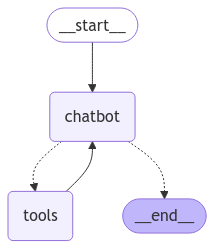

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
import re
def sanitize_name(name: str) -> str:
    """Sanitize the name to match the pattern '^[a-zA-Z0-9_-]+$'."""
    return re.sub(r'[^a-zA-Z0-9_-]', '_', name)

In [ ]:
import asyncio
from langchain_core.messages import HumanMessage, AIMessage
import time

async def chat_loop():
    config = {"configurable": {"thread_id": "1"}}

    while True:
        user_input = await asyncio.get_event_loop().run_in_executor(None, input, "User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        sanitized_name = sanitize_name("Human") or "Anonymous"  # Fallback if sanitized name is empty
        state = {"messages": [HumanMessage(content=user_input, name=sanitized_name)]}

        print("Assistant: ", end="", flush=True)

        max_retries = 3
        retry_delay = 1

        for attempt in range(max_retries):
          try:
            async for chunk in graph.astream(state, config, stream_mode="values"):
              if "messages" in chunk and chunk["messages"]:
                last_message = chunk["messages"][-1]
                if isinstance(last_message, AIMessage):
                  last_message.name = sanitize_name(last_message.name or "AI") or "AI"
                  print(last_message.content, end="", flush=True)
              elif isinstance(last_message, ToolMessage):
                  print(f"\n[Tool Used: {last_message.name}]")
                  print(f"Tool Call ID: {last_message.tool_call_id}")
                  print(f"Content: {last_message.content}")
                  print("Assistant: ", end="", flush=True)
            break
          except Exception as e:
            if attempt < max_retries - 1:
              print(f"\nAn unexpected error occurred: {str(e)}")
              print(f"\nRetrying in {retry_delay} seconds...")
              await asyncio.sleep(retry_delay)
              retry_delay *= 2
            else:
              print(f"\nMax retries reached. OpenAI API error: {str(e)}")
              break

        print("\n")  # New line after the complete response

# Step 18: Execution

In [ ]:
# For Jupyter notebooks and IPython environments
import nest_asyncio
nest_asyncio.apply()

# Run the async function
await chat_loop()

In [ ]:
incoming_policy_violating_transaction = Transaction(
    transaction_id="TRANS123456",
    timestamp=datetime.utcnow(),
    sender=AccountHolder(
        account_id="ACC987654",
        name="Jean Dupont",
        country="France",
        bank="BNP Paribas",
        currency="EUR"
    ),
    recipient=AccountHolder(
        account_id="ACC123456",
        name="Marie Lambert",
        country="United Kingdom",
        bank="Barclays",
        currency="GBP"
    ),
    transaction_details=TransactionDetails(
        amount=50000.00,
        exchange_rate=0.86,
        converted_amount=43000.00,
        purpose="Investment in foreign real estate",
        transaction_type="International wire transfer"
    ),
    audit_trail=[
        AuditTrailEntry(
            action="transaction_initiated",
            timestamp=datetime.utcnow(),
            details="High-value international transfer initiated by sender"
        )
    ]
)